# Shoreline Evolution (clean code)

## 1/ Data Prepocessing

In [1]:
import pandas as pd
import numpy as np

# Read the .xyz file (space or tab delimited)
df = pd.read_csv('data/06_tx_1965-2023_jrk.xyz', delim_whitespace=True, names=['x', 'y', 'z'])

C:\Users\Move\AppData\Local\Temp\ipykernel_14328\1361819395.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('data/06_tx_1965-2023_jrk.xyz', delim_whitespace=True, names=['x', 'y', 'z'])
C:\Users\Move\AppData\Local\Temp\ipykernel_14328\1361819395.py:5: DtypeWarning: Columns (0,1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/06_tx_1965-2023_jrk.xyz', delim_whitespace=True, names=['x', 'y', 'z'])


In [2]:
# remove column names and use the first row as headers
df.columns = df.iloc[0]
df = df[1:]

# create df_xyz that splits the index into x and y columns
df_xyz = df.reset_index()

# handle different possible column names created by reset_index()
if 'index' in df_xyz.columns:
	# index column contains tuples like (x, y)
	df_xyz[['x', 'y']] = pd.DataFrame(df_xyz['index'].tolist(), index=df_xyz.index)
	df_xyz = df_xyz.drop(columns=['index'])
elif 'level_0' in df_xyz.columns and 'level_1' in df_xyz.columns:
	# common names when resetting a MultiIndex without names
	df_xyz = df_xyz.rename(columns={'level_0': 'X', 'level_1': 'Y'})
else:
	# fallback: assume the first two columns are the index levels (coming from reset_index)
	first_two = list(df_xyz.columns[:2])
	df_xyz = df_xyz.rename(columns={first_two[0]: 'X', first_two[1]: 'Y'})

df_xyz

"(X, Y)",X,Y,Z,T,loc
0,109682.41,558181.19,3.77,5-8-1965,900
1,109677.53,558180.09,3.63,5-8-1965,900
2,109672.65,558179.00,3.55,5-8-1965,900
3,109667.77,558177.91,3.41,5-8-1965,900
4,109662.89,558176.82,3.16,5-8-1965,900
...,...,...,...,...,...
1380678,117558.08,579018.26,-1.44,3-4-2023,3081
1380679,117551.46,579025.77,-1.7,3-4-2023,3081
1380680,117544.85,579033.27,-1.88,3-4-2023,3081
1380681,117538.24,579040.77,-2.14,3-4-2023,3081


In [3]:
# Since the data was collected on multiple dates in a year;
# we can view the data collected in the same year by grouping by year
# thus, we create a new column 'year' from 'T'
df_xyz['year'] = pd.to_datetime(df_xyz['T'], format='%d-%m-%Y').dt.year

# df_xyz.groupby('year').size()

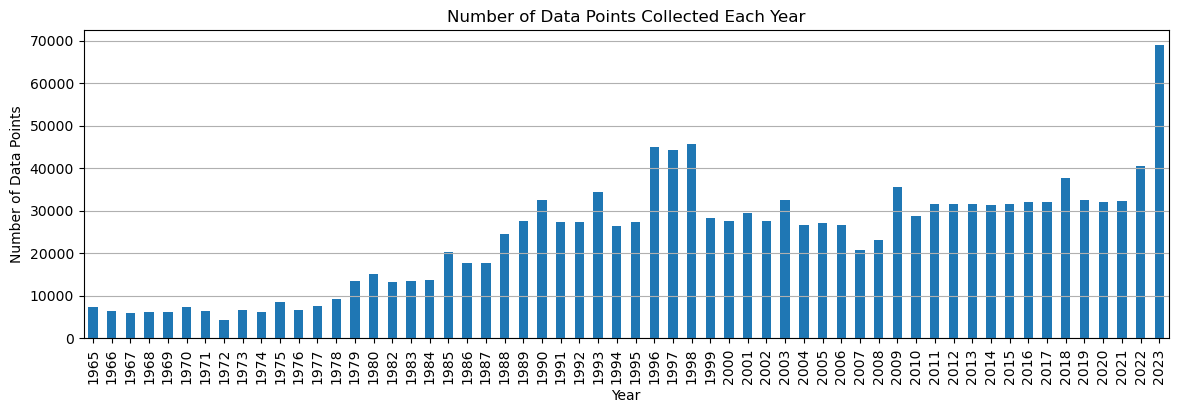

In [4]:
# plot time series of available data points per year
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 4))
df_xyz['year'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points Collected Each Year')
plt.grid(axis='y')
plt.show()

In [5]:
# convert X, Y, Z to numeric (coerce bad values to NaN) before computing min/max
x = pd.to_numeric(df_xyz['X'], errors='coerce')
y = pd.to_numeric(df_xyz['Y'], errors='coerce')
z = pd.to_numeric(df_xyz['Z'], errors='coerce')
year = pd.to_numeric(df_xyz['year'], errors='coerce')

print(f"X: min={x.min()}, max={x.max()}, NaNs={x.isna().sum()}")
print(f"Y: min={y.min()}, max={y.max()}, NaNs={y.isna().sum()}")
print(f"Z: min={z.min()}, max={z.max()}, NaNs={z.isna().sum()}")
print(f"Year: min={int(year.min()) if pd.notna(year.min()) else None}, max={int(year.max()) if pd.notna(year.max()) else None}")

X: min=103755.72, max=119363.46, NaNs=0
Y: min=556933.41, max=580379.14, NaNs=0
Z: min=-17.6, max=23.48, NaNs=0
Year: min=1965, max=2023


## 2/ Data Visualization

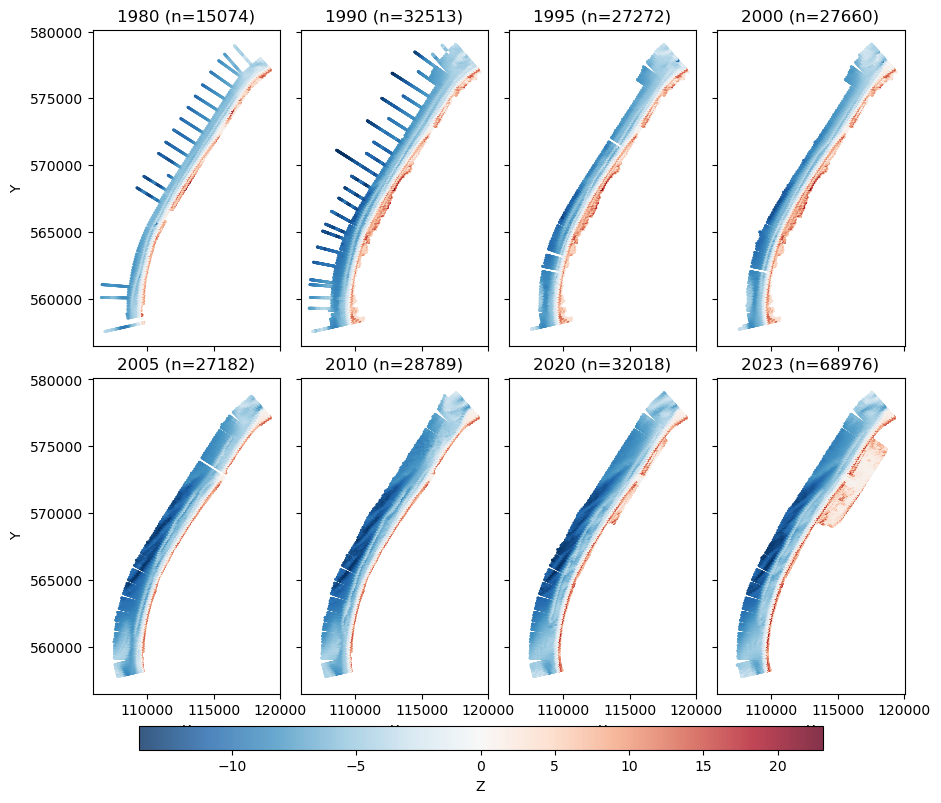

In [6]:
from matplotlib.colors import TwoSlopeNorm

# 2x4 subplot for years [1965,1990,1995,2000,2005,2010,2020,2023]
years = [1980, 1990, 1995, 2000, 2005, 2010, 2020, 2023]
max_points = 100000

# compute global z range across selected years for consistent coloring
z_series = []
for y in years:
    tmp = df_xyz[df_xyz['year'] == y][['X', 'Y', 'Z']].copy()
    tmp[['X', 'Y', 'Z']] = tmp[['X', 'Y', 'Z']].apply(pd.to_numeric, errors='coerce')
    tmp = tmp.dropna(subset=['X', 'Y', 'Z'])
    if not tmp.empty:
        z_series.append(tmp['Z'])
if z_series:
    all_z_sel = pd.concat(z_series)
    zmin, zmax = all_z_sel.min(), all_z_sel.max()
else:
    zmin, zmax = -1, 1

norm = TwoSlopeNorm(vmin=zmin, vcenter=0, vmax=zmax)

fig, axes = plt.subplots(2, 4, figsize=(9, 8), sharex=True, sharey=True)
axes = axes.ravel()
sc = None

# create a colormap normalized to the Z values of a selected year (e.g., 2023)
selected_year = 2023
sel_year = df_xyz[df_xyz['year'] == selected_year].copy()
# normalize with center at 0 so negatives map to red (left of center) and positives to blue
z_vals = pd.to_numeric(sel_year['Z'], errors='coerce')
norm = TwoSlopeNorm(vmin=z_vals.min(), vcenter=0, vmax=z_vals.max())
cmap = plt.get_cmap('RdBu_r')  # reversed RdBu -> red for negative, blue for positive

for i, year in enumerate(years):


    ax = axes[i]
    sel = df_xyz[df_xyz['year'] == year][['X', 'Y', 'Z', 'T', 'loc']].copy()
    sel[['X', 'Y', 'Z']] = sel[['X', 'Y', 'Z']].apply(pd.to_numeric, errors='coerce')
    sel = sel.dropna(subset=['X', 'Y', 'Z'])
    if sel.empty:
        ax.text(0.5, 0.5, f'No rows for {year}', ha='center', va='center')
        ax.set_title(f'{year} (n=0)')
        ax.set_xticks([])
        ax.set_yticks([])
        continue

    if len(sel) > max_points:
        sel = sel.sample(max_points, random_state=1)

    sc = ax.scatter(sel['X'], sel['Y'], c=sel['Z'], cmap=cmap, norm=norm, s=1, alpha=0.8)
    ax.set_title(f'{year} (n={len(sel)})')

    # only label axes on left column and bottom row
    if i % 4 == 0:
        ax.set_ylabel('Y')
    if i // 4 == 1:
        ax.set_xlabel('X')

    ax.set_aspect('equal', 'box')

# hide any unused axes (in case)
for j in range(len(years), len(axes)):
    axes[j].axis('off')

# make plots closer: reduce margins and spacing
plt.subplots_adjust(left=0.06, right=0.98, top=0.95, bottom=0.12, wspace=0.02, hspace=0.1)

# add a single horizontal colorbar at the bottom
if sc is not None:
    cax = fig.add_axes([0.12, 0.05, 0.76, 0.03])  # [left, bottom, width, height] in figure coords
    cb = fig.colorbar(sc, cax=cax, orientation='horizontal', label='Z')
    cb.ax.xaxis.set_ticks_position('bottom')

plt.show()


## 3/ Classification of Datapoints by Depth (z)

### Classify into 4 classes

<img src="Dutch Shore.png" alt="Dutch Shore" width="1000"/>

In [7]:
# ensure Z is numeric
df_xyz['Z'] = pd.to_numeric(df_xyz['Z'], errors='coerce')

# build bins and labels from the input intervals based on Figure 2.1 above
bins = [-np.inf, -8, 0, 3, np.inf]
labels = [
    "-20 ≤ Z < -8 (lower shoreface)",
    "-8 ≤ Z < 0 (upper shoreface)",
    "0 ≤ Z < 3 (beach/intertidal)",
    "Z ≥ 3 (dunes)"
]

# classify using pd.cut; right=False makes intervals left-inclusive ([a, b))
df_xyz['class'] = pd.cut(df_xyz['Z'], bins=bins, labels=labels, right=False, ordered=True)

# quick check
print(df_xyz['class'].value_counts(dropna=False))

class
-8 ≤ Z < 0 (upper shoreface)      646260
Z ≥ 3 (dunes)                     322589
-20 ≤ Z < -8 (lower shoreface)    229091
0 ≤ Z < 3 (beach/intertidal)      182743
Name: count, dtype: int64


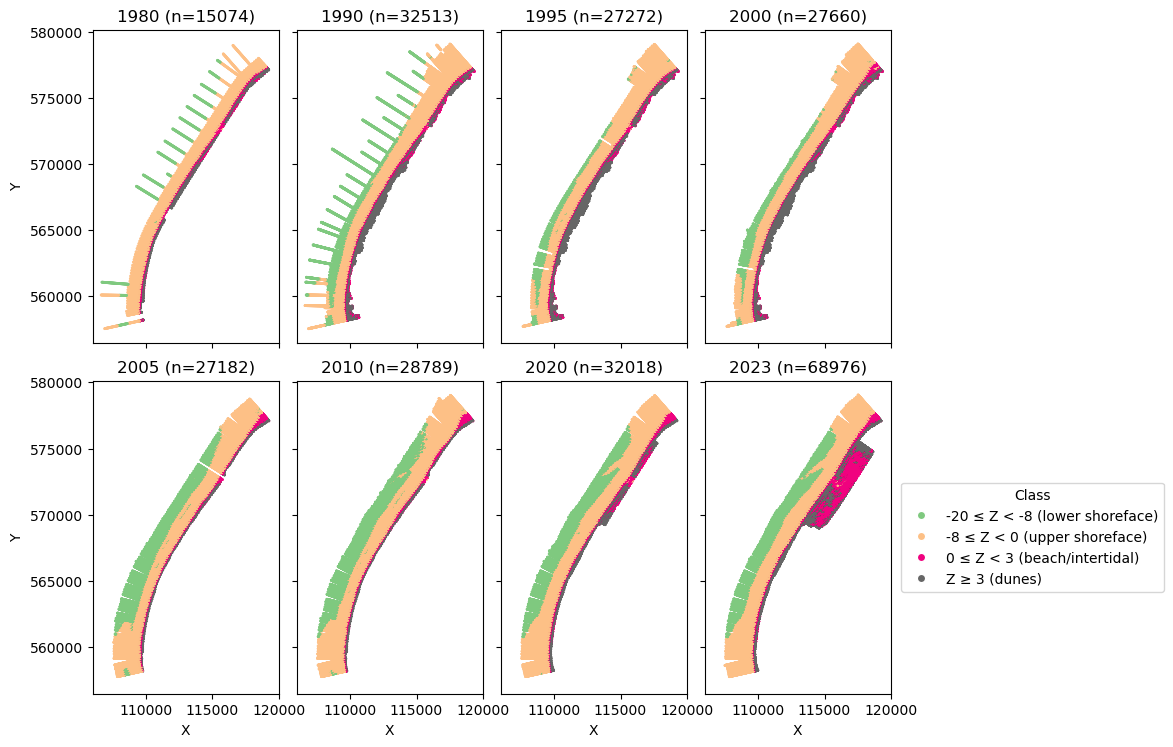

In [8]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

# 2x4 subplot colored by class (discrete) for years [1965,1990,1995,2000,2005,2010,2020,2023]
years_plot = [1980, 1990, 1995, 2000, 2005, 2010, 2020, 2023]

# ensure class exists and is categorical
if 'class' not in df_xyz.columns:
    raise RuntimeError("df_xyz has no 'class' column. Run classification cell first.")

n_classes = int(df_xyz['class'].nunique())
cmap_disc = plt.get_cmap('Accent', max(n_classes, 1))

fig, axes = plt.subplots(2, 4, figsize=(9, 8), sharex=True, sharey=True)
axes = axes.ravel()

sc = None
for i, yr in enumerate(years_plot):
    ax = axes[i]
    sel = df_xyz[df_xyz['year'] == yr][['X', 'Y', 'class']].copy()
    if sel.empty:
        ax.text(0.5, 0.5, f'No rows for {yr}', ha='center', va='center')
        ax.set_title(f'{yr} (n=0)')
        ax.set_xticks([])
        ax.set_yticks([])
        continue

    # ensure numeric coordinates and drop bad rows
    sel[['X', 'Y']] = sel[['X', 'Y']].apply(pd.to_numeric, errors='coerce')
    sel = sel.dropna(subset=['X', 'Y', 'class'])
    if sel.empty:
        ax.text(0.5, 0.5, f'No valid XY for {yr}', ha='center', va='center')
        ax.set_title(f'{yr} (n=0)')
        ax.set_xticks([])
        ax.set_yticks([])
        continue

    # convert class to integer codes for discrete colormap
    # use isinstance on the dtype to avoid deprecated is_categorical_dtype
    if isinstance(sel['class'].dtype, pd.CategoricalDtype):
        class_codes = sel['class'].cat.codes
    else:
        # safe fallback: create categorical and get codes
        class_codes = pd.Categorical(sel['class']).codes

    sc = ax.scatter(sel['X'], sel['Y'], c=class_codes, cmap=cmap_disc,
                    vmin=0, vmax=max(n_classes-1, 0), s=1, alpha=0.9)
    ax.set_title(f'{yr} (n={len(sel)})')
    if i % 4 == 0:
        ax.set_ylabel('Y')
    if i // 4 == 1:
        ax.set_xlabel('X')
    ax.set_aspect('equal', 'box')

# hide any unused axes (if any)
for j in range(len(years_plot), len(axes)):
    axes[j].axis('off')

plt.subplots_adjust(left=0.06, right=0.95, top=0.93, bottom=0.10, wspace=0.08, hspace=0.12)

# build legend from bins (if present) else generic class labels
legend_labels = []
# Prefer the categorical categories from df_xyz so legend matches plotted class order
if 'class' in df_xyz.columns:
    if isinstance(df_xyz['class'].dtype, pd.CategoricalDtype):
        legend_labels = list(df_xyz['class'].cat.categories)
    else:
        legend_labels = list(pd.Categorical(df_xyz['class']).categories)
else:
    legend_labels = []

# Fallback to bins-based labels if categories length doesn't match n_classes
if len(legend_labels) != n_classes:
    legend_labels = []
    if 'bins' in globals() and isinstance(bins, (list, tuple)) and len(bins) >= n_classes + 1:
        for idx in range(n_classes):
            lo = bins[idx]
            hi = bins[idx + 1]
            if lo == -float('inf'):
                lab = f'Z < {hi}'
            elif hi == float('inf'):
                lab = f'Z ≥ {lo}'
            else:
                lab = f'{lo} ≤ Z < {hi}'
            legend_labels.append(lab)
    else:
        legend_labels = [f'class {i}' for i in range(n_classes)]

# create legend handles
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap_disc(i),
                  markersize=6, label=legend_labels[i]) for i in range(n_classes)]

# place legend on the right
axes[-1].legend(handles=handles, title='Class', bbox_to_anchor=(1.02, 0.5), loc='center left')

plt.show()

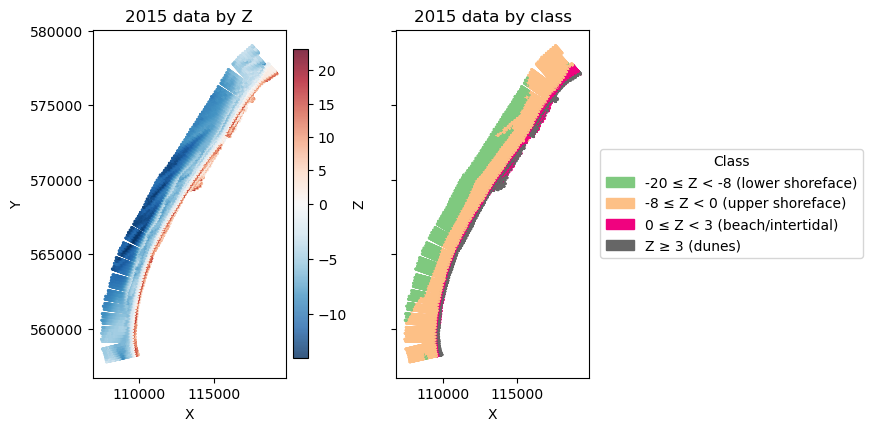

In [9]:
# 1x2 subplot: left = colored by Z (same as before), right = colored by class
selected_year = 2015
max_points = 100000

sel_year = df_xyz[df_xyz['year'] == selected_year].copy()
sel_year[['X','Y','Z']] = sel_year[['X','Y','Z']].apply(pd.to_numeric, errors='coerce')
df2 = sel_year.dropna(subset=['X','Y','Z'])

if df2.empty:
    print(f"No rows for year = {selected_year}")
else:
    if len(df2) > max_points:
        df2 = df2.sample(max_points, random_state=1)

    z_vals = df2['Z']
    norm2d = TwoSlopeNorm(vmin=z_vals.min(), vcenter=0, vmax=z_vals.max())

    fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

    # left: color by Z
    sc_left = ax_l.scatter(df2['X'], df2['Y'], c=z_vals, cmap=cmap, norm=norm2d, s=1, alpha=0.8)
    ax_l.set_title(f'{selected_year} data by Z')
    ax_l.set_xlabel('X')
    ax_l.set_ylabel('Y')
    ax_l.set_aspect('equal', 'box')
    fig.colorbar(sc_left, ax=ax_l, label='Z', fraction=0.046, pad=0.02)

    # right: color by class (categorical)
    if 'class' not in df2.columns:
        ax_r.text(0.5, 0.5, 'No class column', ha='center', va='center')
        ax_r.set_title('Class (missing)')
        ax_r.set_xticks([])
        ax_r.set_yticks([])
    else:
        # ensure categorical and get codes
        if not isinstance(df2['class'].dtype, pd.CategoricalDtype):
            df2['class'] = pd.Categorical(df2['class'])
        class_cats = list(df2['class'].cat.categories)
        class_codes = df2['class'].cat.codes
        n_classes = len(class_cats)

        # ensure a discrete colormap is available
        try:
            cmap_disc_use = cmap_disc
        except NameError:
            cmap_disc_use = plt.get_cmap('Set2', max(n_classes, 1))

        sc_right = ax_r.scatter(df2['X'], df2['Y'], c=class_codes, cmap=cmap_disc_use,
                                vmin=0, vmax=max(n_classes-1, 0), s=1, alpha=0.9)
        ax_r.set_title(f'{selected_year} data by class')
        ax_r.set_xlabel('X')
        ax_r.set_aspect('equal', 'box')

        # legend for classes using discrete colors
        # get n colors from the discrete cmap
        colors = cmap_disc_use(np.linspace(0, 1, max(n_classes, 1)))
        handles = [mpatches.Patch(color=colors[i], label=class_cats[i]) for i in range(n_classes)]
        ax_r.legend(handles=handles, title='Class', bbox_to_anchor=(1.02, 0.5), loc='center left')

    plt.subplots_adjust(left=0.06, right=0.92, top=0.95, bottom=0.08, wspace=0.05)
    plt.show()


In [10]:
from typing import List, Tuple

import numpy as np
from typing import List, Tuple
def tilted_square_from_point(point: Tuple[float, float],
                             size: float,
                             degree: float = 0.0,
                             center: bool = True) -> List[Tuple[float, float]]:
    """
    Return 4 corner coordinates of a square of side `size` rotated by `degree` (deg).
    Parameters:
    - point: (x, y) anchor coordinate. If center=True this is the square center,
             otherwise it is the top-left corner of the unrotated square.
    - size: side length of the square (positive).
    - degree: rotation angle in degrees (positive = counter-clockwise).
    - center: whether `point` is the square center (True) or top-left corner (False).
    Returns:
    - list of 4 (x, y) tuples in counter-clockwise order starting from the top-left corner
      of the rotated square.
    """
    p = np.asarray(point, dtype=float)
    if p.shape != (2,):
        raise ValueError("point must be a 2D coordinate (x, y).")
    if size <= 0:
        raise ValueError("size must be positive.")

    h = size / 2.0
    # corners of an unrotated square centered at origin (top-left, top-right, bottom-right, bottom-left)
    corners = np.array([[-h,  h],
                        [ h,  h],
                        [ h, -h],
                        [-h, -h]], dtype=float)

    if not center:
        # if point is top-left of unrotated square, shift so that point becomes top-left
        # compute center offset: top-left relative to center is (-h, h)
        center_offset = np.array([h, -h])
        origin = p + center_offset
    else:
        origin = p.copy()

    # rotation matrix (counter-clockwise)
    theta = np.deg2rad(degree)
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    rotated = (R @ corners.T).T + origin  # rotate then translate to origin
    return [tuple(pt) for pt in rotated]

# example usage
tilted_square_from_point((1, 2), size=3, degree=30, center=True)

[(-1.049038105676658, 2.549038105676658),
 (1.549038105676658, 4.049038105676658),
 (3.049038105676658, 1.450961894323342),
 (0.4509618943233419, -0.049038105676658006)]

In [11]:
# create box-1
assigned_coords = (114000, 573000)
box_size = 1400
box_angle = 55  # degrees counter-clockwise from horizontal
box1 = tilted_square_from_point(assigned_coords, size=box_size, degree=box_angle, center=False)
box1

[(113725.09006355198, 572128.0970744435),
 (114528.09707444343, 573274.909936448),
 (115674.90993644802, 572471.9029255565),
 (114871.90292555657, 571325.090063552)]

In [12]:
# create box-2
assigned_coords = (112000, 570000)
box_size = 1400
box_angle = 60  # degrees counter-clockwise from horizontal
box2 = tilted_square_from_point(assigned_coords, size=box_size, degree=box_angle, center=False)
box2

[(111743.78221735089, 569043.7822173509),
 (112443.78221735089, 570256.2177826491),
 (113656.21778264911, 569556.2177826491),
 (112956.21778264911, 568343.7822173509)]

In [13]:
# create box-3
assigned_coords = (109200, 565000)
box_size = 1400
box_angle = 70  # degrees counter-clockwise from horizontal
box3 = tilted_square_from_point(assigned_coords, size=box_size, degree=box_angle, center=False)
box3

[(109002.8010651219, 563881.6292657779),
 (109481.62926577784, 565197.1989348781),
 (110797.1989348781, 564718.3707342221),
 (110318.37073422216, 563402.8010651219)]

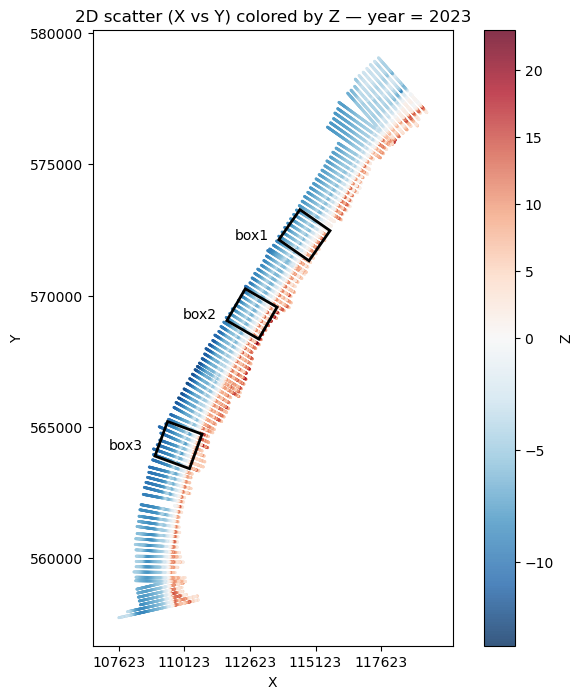

In [14]:
from matplotlib import patches as _patches

# plot Z for year XXXX and overlay box1
sel_year = 2000
sel_year_data = df_xyz[df_xyz['year'] == sel_year].copy()
sel_year_data[['X', 'Y', 'Z']] = sel_year_data[['X', 'Y', 'Z']].apply(pd.to_numeric, errors='coerce')
sel_year_data = sel_year_data.dropna(subset=['X', 'Y', 'Z'])

if sel_year_data.empty:
    print(f"No data for year {sel_year}")
else:
    # limit points for plotting if necessary
    plot_df = sel_year_data
    if len(plot_df) > max_points:
        plot_df = plot_df.sample(max_points, random_state=1)

    fig, ax = plt.subplots(figsize=(8, 8))
    sc_local = ax.scatter(plot_df['X'], plot_df['Y'], c=plot_df['Z'],
                          cmap=cmap, norm=norm, s=1, alpha=0.8)
    cbar_local = fig.colorbar(sc_local, ax=ax, label='Z')
    ax.set_title('2D scatter (X vs Y) colored by Z — year = 2023')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal', 'box')
    # set x axis interval to 5000
    ax.set_xlim(left=plot_df['X'].min()-1000, right=plot_df['X'].max()+1000)
    ax.set_xticks(np.arange(int(plot_df['X'].min()), int(plot_df['X'].max())+1, 2500))

    # overlay tilted square (box1)
    poly_coords = list(box1)
    # ensure polygon is closed (patch takes care of closing, but make explicit)
    if poly_coords[0] != poly_coords[-1]:
        poly_coords = poly_coords + [poly_coords[0]]
    poly = _patches.Polygon(poly_coords, closed=True,
                            edgecolor='black', facecolor='none', linewidth=2)
    ax.add_patch(poly)
    # add label box1
    mid_x = (sum(x for x, y in box1) / 4) - 2000
    mid_y = sum(y for x, y in box1) / 4
    ax.text(mid_x, mid_y, 'box1', color='black', fontsize=10, ha='center', va='center')

    # overlay tilted square (box2)
    poly_coords = list(box2)
    # ensure polygon is closed (patch takes care of closing, but make explicit)
    if poly_coords[0] != poly_coords[-1]:
        poly_coords = poly_coords + [poly_coords[0]]
    poly = _patches.Polygon(poly_coords, closed=True,
                            edgecolor='black', facecolor='none', linewidth=2)
    ax.add_patch(poly)
    # add label box2
    mid_x = (sum(x for x, y in box2) / 4) - 2000
    mid_y = sum(y for x, y in box2) / 4
    ax.text(mid_x, mid_y, 'box2', color='black', fontsize=10, ha='center', va='center')

    # overlay tilted square (box3)
    poly_coords = list(box3)
    # ensure polygon is closed (patch takes care of closing, but make explicit)
    if poly_coords[0] != poly_coords[-1]:
        poly_coords = poly_coords + [poly_coords[0]]
    poly = _patches.Polygon(poly_coords, closed=True,
                            edgecolor='black', facecolor='none', linewidth=2)
    ax.add_patch(poly)
    # add label box3
    mid_x = (sum(x for x, y in box3) / 4) - 2000
    mid_y = sum(y for x, y in box3) / 4
    ax.text(mid_x, mid_y, 'box3', color='black', fontsize=10, ha='center', va='center')

    # optional: mark the assigned center coordinate
    #ax.plot(assigned_coords[0], assigned_coords[1], marker='x', color='black', markersize=8)
    #ax.text(assigned_coords[0], assigned_coords[1], ' center', va='bottom', ha='left', color='black', fontsize=9)

    plt.show()

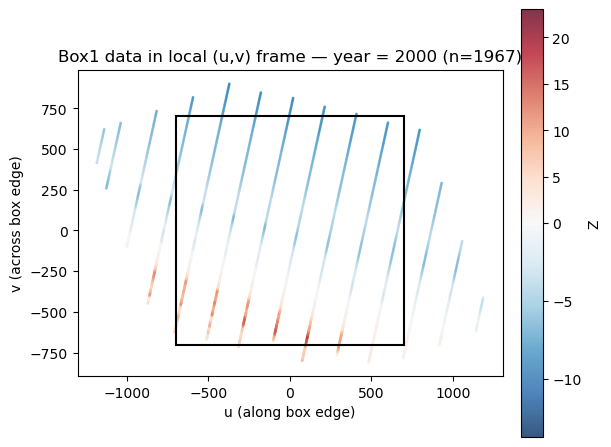

In [15]:
import numpy as np

# Project points in box1 to a local (u,v) frame so the box becomes axis-aligned

# choose year (prefer existing plot_year/sel_year)
plot_year = plot_year if 'plot_year' in globals() else (sel_year if 'sel_year' in globals() else year)

# prepare selection for that year and box1 axis-aligned bbox
sel = df_xyz[df_xyz['year'] == plot_year].copy()
sel[['X', 'Y', 'Z']] = sel[['X', 'Y', 'Z']].apply(pd.to_numeric, errors='coerce')
sel = sel.dropna(subset=['X', 'Y', 'Z'])

if sel.empty:
    print(f"No data for year {plot_year}")
else:
    xs = [p[0] for p in box1]
    ys = [p[1] for p in box1]
    xmin, xmax = min(xs), max(xs)
    ymin, ymax = min(ys), max(ys)

    in_bbox = sel[
        (sel['X'] >= xmin) & (sel['X'] <= xmax) &
        (sel['Y'] >= ymin) & (sel['Y'] <= ymax)
    ].copy()

    if in_bbox.empty:
        print(f"No points in axis-aligned bbox of box1 for year {plot_year}")
    else:
        # optional downsample for plotting
        if len(in_bbox) > max_points:
            in_bbox = in_bbox.sample(max_points, random_state=1)

        # compute box1 center (use mean of corners) and rotation to align box with axes
        center_box1 = np.mean(np.array(box1), axis=0)

        # use existing R (rotation by -box_angle) if available, else compute
        if 'R' in globals():
            R_proj = R
        else:
            theta = -np.deg2rad(box_angle)  # rotate points by -angle to align box
            R_proj = np.array([[np.cos(theta), -np.sin(theta)],
                               [np.sin(theta),  np.cos(theta)]])

        pts = in_bbox[['X', 'Y']].to_numpy()
        # translate to box center, rotate
        uv = (R_proj @ (pts - center_box1).T).T

        in_bbox = in_bbox.reset_index(drop=True)
        in_bbox['u'] = uv[:, 0]
        in_bbox['v'] = uv[:, 1]

        # plot in (u,v) coordinates
        fig, ax = plt.subplots(figsize=(6, 6))
        sc = ax.scatter(in_bbox['u'], in_bbox['v'], c=in_bbox['Z'],
                        cmap=cmap, norm=norm, s=1, alpha=0.8)
        ax.set_title(f'Box1 data in local (u,v) frame — year = {plot_year} (n={len(in_bbox)})')
        ax.set_xlabel('u (along box edge)')
        ax.set_ylabel('v (across box edge)')
        ax.set_aspect('equal', 'box')

        # overlay the axis-aligned box (rot_box is half-size corners around origin if present)
        if 'rot_box' in globals():
            poly = _patches.Polygon(rot_box, closed=True, edgecolor='k', facecolor='none', linewidth=1.5)
            ax.add_patch(poly)
        else:
            # fallback: draw rectangle from box_size/2
            h = box_size / 2.0
            rect = _patches.Rectangle((-h, -h), 2*h, 2*h, edgecolor='k', facecolor='none', linewidth=1.5)
            ax.add_patch(rect)

        # set view limits with margin
        xlim = (in_bbox['u'].min(), in_bbox['u'].max())
        ylim = (in_bbox['v'].min(), in_bbox['v'].max())
        xmargin = max(50, (xlim[1] - xlim[0]) * 0.05)
        ymargin = max(50, (ylim[1] - ylim[0]) * 0.05)
        ax.set_xlim(xlim[0] - xmargin, xlim[1] + xmargin)
        ax.set_ylim(ylim[0] - ymargin, ylim[1] + ymargin)

        fig.colorbar(sc, ax=ax, label='Z', fraction=0.046, pad=0.04)
        plt.show()

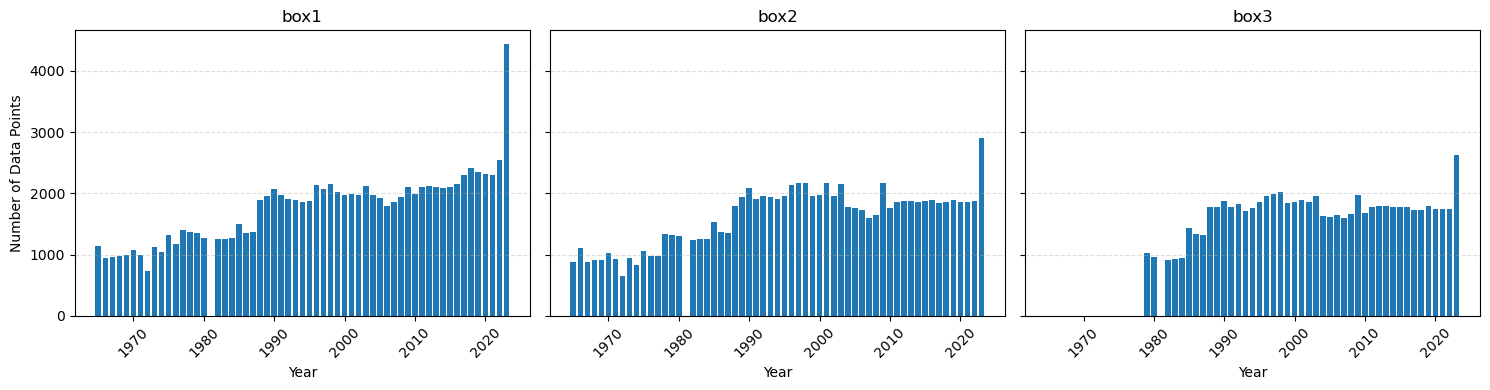

In [16]:
# count data points in box1 for all years
# count data points in box1/box2/box3 for all years
boxes_use = globals().get('boxes', [globals().get('box1'), globals().get('box2'), globals().get('box3')])
box_names_use = globals().get('box_names', [f'box{i+1}' for i in range(len(boxes_use))])

box_counts = {name: {} for name in box_names_use}
years = sorted(df_xyz['year'].dropna().unique())

for yr in years:
    sel = df_xyz[df_xyz['year'] == yr].copy()
    sel[['X', 'Y', 'Z']] = sel[['X', 'Y', 'Z']].apply(pd.to_numeric, errors='coerce')
    sel = sel.dropna(subset=['X', 'Y', 'Z'])
    for name, box in zip(box_names_use, boxes_use):
        if box is None:
            box_counts[name][yr] = 0
            continue
        xs = [p[0] for p in box]
        ys = [p[1] for p in box]
        xmin, xmax = min(xs), max(xs)
        ymin, ymax = min(ys), max(ys)
        in_bbox = sel[(sel['X'] >= xmin) & (sel['X'] <= xmax) & (sel['Y'] >= ymin) & (sel['Y'] <= ymax)]
        box_counts[name][yr] = len(in_bbox)

# DataFrame view (years as index, boxes as columns)
box_counts_df = pd.DataFrame(box_counts).fillna(0).astype(int).sort_index()

# 1x3 subplots: counts per year for each box
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# ensure years are int for plotting
x_years = box_counts_df.index.astype(int)

for ax, name in zip(axes, box_counts_df.columns[:3]):
    counts = box_counts_df[name]
    ax.bar(x_years, counts.values, width=0.8)
    ax.set_title(f'{name}')
    ax.set_xlabel('Year')
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    ax.tick_params(axis='x', rotation=45)

axes[0].set_ylabel('Number of Data Points')

plt.tight_layout()
plt.show()

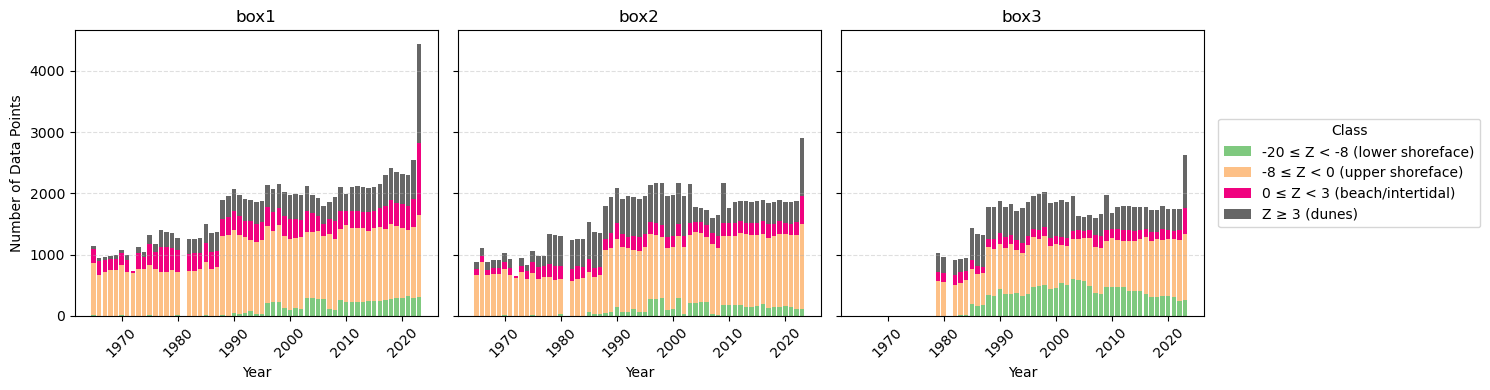

In [20]:
from collections import OrderedDict

boxes_use = [box1, box2, box3]
box_names_use = ['box1', 'box2', 'box3']

# get sorted years and class categories (preserve order if categorical)
years = sorted(df_xyz['year'].dropna().unique())
if 'class' in df_xyz.columns and isinstance(df_xyz['class'].dtype, pd.CategoricalDtype):
    classes = list(df_xyz['class'].cat.categories)
else:
    classes = globals().get('categories', sorted(df_xyz['class'].dropna().unique()))

# initialize storage: for each box, a DataFrame with years x classes
box_counts = OrderedDict()
for name in box_names_use:
    box_counts[name] = pd.DataFrame(0, index=years, columns=classes, dtype=int)

# compute counts
for yr in years:
    sel = df_xyz[df_xyz['year'] == yr].copy()
    sel[['X', 'Y', 'Z']] = sel[['X', 'Y', 'Z']].apply(pd.to_numeric, errors='coerce')
    sel = sel.dropna(subset=['X', 'Y', 'Z', 'class'])
    if sel.empty:
        continue
    for name, box in zip(box_names_use, boxes_use):
        if box is None:
            continue
        xs = [p[0] for p in box]
        ys = [p[1] for p in box]
        xmin, xmax = min(xs), max(xs)
        ymin, ymax = min(ys), max(ys)
        in_bbox = sel[(sel['X'] >= xmin) & (sel['X'] <= xmax) & (sel['Y'] >= ymin) & (sel['Y'] <= ymax)]
        if in_bbox.empty:
            continue
        # count by class and fill into DataFrame
        counts = in_bbox['class'].value_counts()
        for cls, cnt in counts.items():
            # some class labels may differ in type; cast to str to match columns if necessary
            if cls in box_counts[name].columns:
                box_counts[name].at[yr, cls] = int(cnt)
            else:
                # try matching by string
                for col in box_counts[name].columns:
                    if str(col) == str(cls):
                        box_counts[name].at[yr, col] = int(cnt)
                        break

# Plot stacked bar charts (one subplot per box)
fig, axes = plt.subplots(1, min(3, len(box_names_use)), figsize=(15, 4), sharey=True)
if not isinstance(axes, (list, np.ndarray)):
    axes = [axes]

# choose discrete colors
try:
    cmap_disc_use = cmap_disc
except NameError:
    cmap_disc_use = plt.get_cmap('tab10', max(len(classes), 1))
colors = cmap_disc_use(np.linspace(0, 1, max(len(classes), 1)))

x_years = np.array(years, dtype=int)

for ax, name in zip(axes, list(box_counts.keys())[:len(axes)]):
    dfc = box_counts[name].reindex(index=years, columns=classes).fillna(0).astype(int)
    bottom = np.zeros(len(dfc), dtype=int)
    for i, cls in enumerate(dfc.columns):
        vals = dfc[cls].values
        ax.bar(x_years, vals, bottom=bottom, color=colors[i % len(colors)], width=0.8, label=str(cls))
        bottom += vals
    ax.set_title(name)
    ax.set_xlabel('Year')
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    ax.tick_params(axis='x', rotation=45)

axes[0].set_ylabel('Number of Data Points')
# legend on the rightmost axis
axes[-1].legend(title='Class', bbox_to_anchor=(1.02, 0.5), loc='center left')

plt.tight_layout()
plt.show()

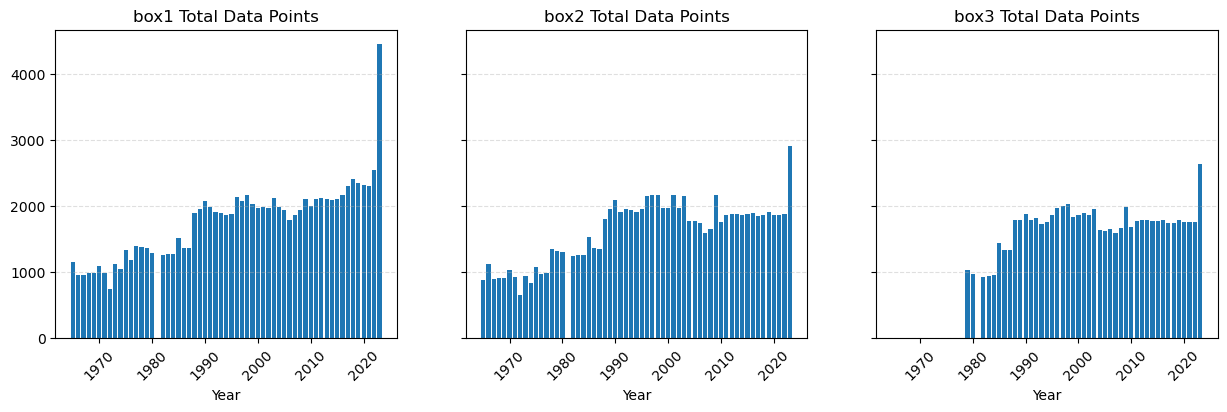

In [21]:
# plot the number of data points in each year for box1, box2, box3; plot 1*3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for ax, (name, df_counts) in zip(axes, box_counts.items()):
    total_counts = df_counts.sum(axis=1)
    x_years = total_counts.index.astype(int)
    ax.bar(x_years, total_counts.values, width=0.8)
    ax.set_title(f'{name} Total Data Points')
    ax.set_xlabel('Year')
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    ax.tick_params(axis='x', rotation=45)

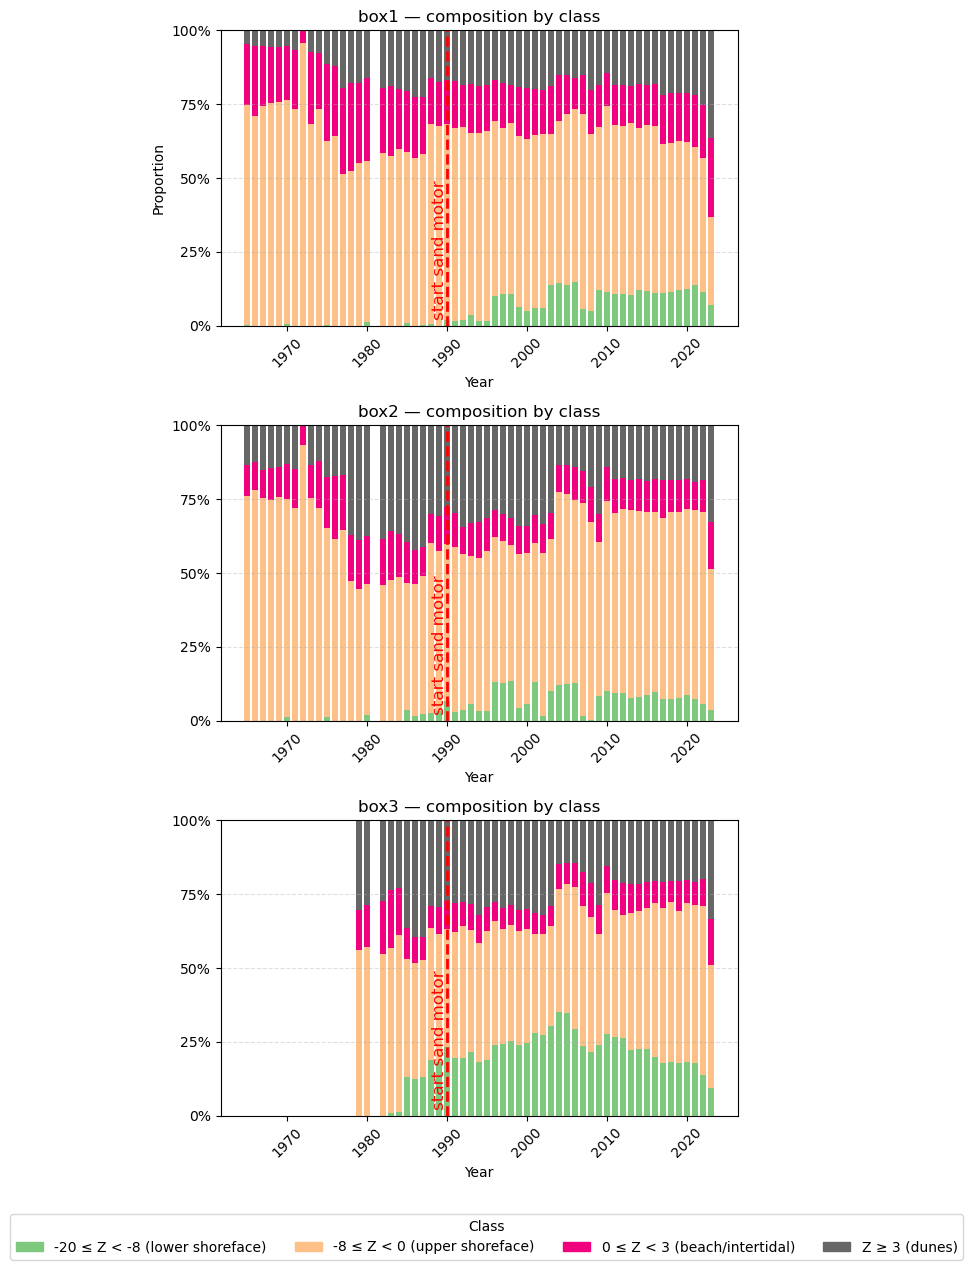

In [19]:
from collections import OrderedDict

boxes_use = [box1, box2, box3]
box_names_use = ['box1', 'box2', 'box3']

years = sorted(df_xyz['year'].dropna().unique())
if 'class' in df_xyz.columns and isinstance(df_xyz['class'].dtype, pd.CategoricalDtype):
    classes = list(df_xyz['class'].cat.categories)
else:
    classes = globals().get('categories', sorted(df_xyz['class'].dropna().unique()))

box_counts = OrderedDict()
for name in box_names_use:
    box_counts[name] = pd.DataFrame(0, index=years, columns=classes, dtype=int)

for yr in years:
    sel = df_xyz[df_xyz['year'] == yr].copy()
    sel[['X', 'Y', 'Z']] = sel[['X', 'Y', 'Z']].apply(pd.to_numeric, errors='coerce')
    sel = sel.dropna(subset=['X', 'Y', 'Z', 'class'])
    if sel.empty:
        continue
    for name, box in zip(box_names_use, boxes_use):
        if box is None:
            continue
        xs = [p[0] for p in box]
        ys = [p[1] for p in box]
        xmin, xmax = min(xs), max(xs)
        ymin, ymax = min(ys), max(ys)
        in_bbox = sel[(sel['X'] >= xmin) & (sel['X'] <= xmax) & (sel['Y'] >= ymin) & (sel['Y'] <= ymax)]
        if in_bbox.empty:
            continue
        counts = in_bbox['class'].value_counts()
        for cls, cnt in counts.items():
            if cls in box_counts[name].columns:
                box_counts[name].at[yr, cls] = int(cnt)
            else:
                for col in box_counts[name].columns:
                    if str(col) == str(cls):
                        box_counts[name].at[yr, col] = int(cnt)
                        break

# Plot composition charts (100% stacked bars) — 3 rows x 1 column (one box per row)
fig, axes = plt.subplots(3, 1, figsize=(7, 12), sharey=True)
# ensure axes is iterable 1D
axes = np.array(axes).ravel()

# discrete colors (reuse cmap_disc if present)
try:
    cmap_disc_use = cmap_disc
except NameError:
    cmap_disc_use = plt.get_cmap('tab10', max(len(classes), 1))
colors = cmap_disc_use(np.linspace(0, 1, max(len(classes), 1)))

x_years = np.array(years, dtype=int)

for ax, name in zip(axes, list(box_counts.keys())[:len(axes)]):
    dfc = box_counts[name].reindex(index=years, columns=classes).fillna(0).astype(int)
    # convert to proportions per year (row-wise)
    row_sums = dfc.sum(axis=1).replace(0, np.nan)
    df_prop = dfc.div(row_sums, axis=0).fillna(0)

    bottom = np.zeros(len(df_prop), dtype=float)
    for i, cls in enumerate(df_prop.columns):
        vals = df_prop[cls].values
        ax.bar(x_years, vals, bottom=bottom, color=colors[i % len(colors)], width=0.8, label=str(cls))
        bottom += vals

    ax.set_title(f'{name} — composition by class')
    ax.set_xlabel('Year')
    ax.set_ylim(0, 1)
    ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    ax.tick_params(axis='x', rotation=45)

    # add vetical line at 1990; label 'start sand motor'
    ax.axvline(x=1990, color='red', linestyle='--', linewidth=2)
    ax.text(1990, 0.02, 'start sand motor', color='red', fontsize=12, ha='right', va='bottom', rotation=90)

axes[0].set_ylabel('Proportion')

# legend on the right of figure (use bottom axis for anchor)
handles = [mpatches.Patch(color=colors[i % len(colors)], label=str(cls)) for i, cls in enumerate(classes)]
ncol = min(len(classes), 4)
fig.legend(handles=handles, title='Class', loc='lower center', bbox_to_anchor=(0.5, -0.06), ncol=ncol)

# leave room on the right for the legend
plt.tight_layout(rect=(0, 0, 0.88, 1.0))
plt.show()

### Calculate areas

In [ ]:
# Calculate area (m^2) per class per year for each box (uses df_xyz, box_names_use, boxes_use)
# Result: two MultiIndex DataFrames -> area_m2[box][year, class], pct[box][year, class_percent]

# build boxes dict (xmin/xmax/ymin/ymax) from corner coords (boxes_use & box_names_use are present)
boxes = {}
for name, coords in zip(box_names_use, boxes_use):
    xs = [p[0] for p in coords]
    ys = [p[1] for p in coords]
    boxes[name] = {
        'coords': coords,
        'xmin': float(min(xs)),
        'xmax': float(max(xs)),
        'ymin': float(min(ys)),
        'ymax': float(max(ys))
    }

box_area_dfs = {}
box_pct_dfs = {}

for name, b in boxes.items():
    # select points inside axis-aligned bbox for that box (use df_xyz)
    # NOTE: convert X/Y to numeric before doing further numeric operations to avoid mixed-type comparisons
    mask_x = pd.to_numeric(df_xyz['X'], errors='coerce').ge(b['xmin']) & pd.to_numeric(df_xyz['X'], errors='coerce').le(b['xmax'])
    mask_y = pd.to_numeric(df_xyz['Y'], errors='coerce').ge(b['ymin']) & pd.to_numeric(df_xyz['Y'], errors='coerce').le(b['ymax'])
    sel = df_xyz[mask_x & mask_y].copy()

    # convert coordinate columns to numeric (in-place) and drop rows missing required fields
    sel[['X', 'Y']] = sel[['X', 'Y']].apply(pd.to_numeric, errors='coerce')
    sel = sel.dropna(subset=['X', 'Y', 'class', 'year']).copy()

    if sel.empty:
        box_area_dfs[name] = pd.DataFrame()  # empty
        box_pct_dfs[name] = pd.DataFrame()
        continue

    # infer cell area inside this box from unique X/Y spacing (fallback to global median spacing)
    # ensure unique arrays are numeric
    xs_unique = np.sort(sel['X'].unique())
    ys_unique = np.sort(sel['Y'].unique())
    try:
        # fallback to global numeric X/Y if needed
        global_x = pd.to_numeric(df_xyz['X'], errors='coerce').dropna().unique()
        global_y = pd.to_numeric(df_xyz['Y'], errors='coerce').dropna().unique()

        if len(xs_unique) > 1:
            dx = np.median(np.diff(xs_unique))
        elif len(global_x) > 1:
            dx = np.median(np.diff(np.sort(global_x)))
        else:
            dx = np.nan

        if len(ys_unique) > 1:
            dy = np.median(np.diff(ys_unique))
        elif len(global_y) > 1:
            dy = np.median(np.diff(np.sort(global_y)))
        else:
            dy = np.nan

        # if dx/dy are still NaN, fallback to box_size**2 or 1.0
        if np.isnan(dx) or np.isnan(dy):
            raise ValueError("Could not infer dx/dy from data")

        Acell = float(abs(dx * dy))
    except Exception:
        Acell = float(box_size**2) if 'box_size' in globals() else 1.0

    # count cells per (year, class) and compute area
    counts = sel.groupby(['year', 'class']).size().reset_index(name='n_cells')
    counts['area_m2'] = counts['n_cells'] * Acell

    # pivot to wide (years x classes)
    df_area = counts.pivot_table(index='year', columns='class', values='area_m2', aggfunc='sum', fill_value=0.0)
    df_pct = df_area.div(df_area.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0) * 100.0

    box_area_dfs[name] = df_area.sort_index()
    box_pct_dfs[name] = df_pct.sort_index()

# Combine into MultiIndex DataFrames: top-level = box name, second = class
# If all box dfs are empty, concat will raise; guard that case.
if any(not df.empty for df in box_area_dfs.values()):
    area_combined = pd.concat(box_area_dfs, axis=1).fillna(0.0)
else:
    area_combined = pd.DataFrame()

if any(not df.empty for df in box_pct_dfs.values()):
    pct_combined = pd.concat(box_pct_dfs, axis=1).fillna(0.0)
else:
    pct_combined = pd.DataFrame()

# show results
print("Inferred cell area per box (m^2):")
for name, dfb in box_area_dfs.items():
    print(f" - {name}: table shape {dfb.shape}")

# display results
display(area_combined.head())
display(pct_combined.head())


C:\Users\Move\AppData\Local\Temp\ipykernel_14328\2922376578.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = sel.groupby(['year', 'class']).size().reset_index(name='n_cells')
C:\Users\Move\AppData\Local\Temp\ipykernel_14328\2922376578.py:72: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_area = counts.pivot_table(index='year', columns='class', values='area_m2', aggfunc='sum', fill_value=0.0)
C:\Users\Move\AppData\Local\Temp\ipykernel_14328\2922376578.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or

Inferred cell area per box (m^2):
 - box1: table shape (58, 4)
 - box2: table shape (58, 4)
 - box3: table shape (44, 4)


C:\Users\Move\AppData\Local\Temp\ipykernel_14328\2922376578.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = sel.groupby(['year', 'class']).size().reset_index(name='n_cells')
C:\Users\Move\AppData\Local\Temp\ipykernel_14328\2922376578.py:72: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_area = counts.pivot_table(index='year', columns='class', values='area_m2', aggfunc='sum', fill_value=0.0)


box1                               \
class -20 ≤ Z < -8 (lower shoreface) -8 ≤ Z < 0 (upper shoreface)   
year                                                                
1965                           0.174                      37.0620   
1966                           0.000                      29.1885   
1967                           0.000                      30.9285   
1968                           0.000                      32.1900   
1969                           0.000                      32.4945   

                                                  \
class 0 ≤ Z < 3 (beach/intertidal) Z ≥ 3 (dunes)   
year                                               
1965                       10.3095        2.3055   
1966                        9.7440        2.2620   
1967                        8.3520        2.2620   
1968                        8.2215        2.3490   
1969                        8.0040        2.3925   

                                box2                               \
class -20 ≤ Z < -8 (lower shoreface) -8 ≤ Z < 0 (upper shoreface)   
year                                                                
1965                             0.0                      130.455   
1966                             0.0                      169.845   
1967                             0.0                      130.065   
1968                             0.0                      132.210   
1969                             0.0                      134.355   

                                                  \
class 0 ≤ Z < 3 (beach/intertidal) Z ≥ 3 (dunes)   
year                                               
1965                        17.550        23.205   
1966                        20.085        27.105   
1967                        16.770        25.935   
1968                        19.500        25.350   
1969                        18.135        25.155   

                                box3                               \
class -20 ≤ Z < -8 (lower shoreface) -8 ≤ Z < 0 (upper shoreface)   
year                                                                
1965                             0.0                          0.0   
1966                             0.0                          0.0   
1967                             0.0                          0.0   
1968                             0.0                          0.0   
1969                             0.0                          0.0   

                                                  
class 0 ≤ Z < 3 (beach/intertidal) Z ≥ 3 (dunes)  
year                                              
1965                           0.0           0.0  
1966                           0.0           0.0  
1967                           0.0           0.0  
1968                           0.0           0.0  
1969                           0.0           0.0

box1                               \
class -20 ≤ Z < -8 (lower shoreface) -8 ≤ Z < 0 (upper shoreface)   
year                                                                
1965                         0.34904                    74.345550   
1966                         0.00000                    70.855333   
1967                         0.00000                    74.450262   
1968                         0.00000                    75.279756   
1969                         0.00000                    75.760649   

                                                  \
class 0 ≤ Z < 3 (beach/intertidal) Z ≥ 3 (dunes)   
year                                               
1965                     20.680628      4.624782   
1966                     23.653643      5.491024   
1967                     20.104712      5.445026   
1968                     19.226857      5.493388   
1969                     18.661258      5.578093   

                                box2                               \
class -20 ≤ Z < -8 (lower shoreface) -8 ≤ Z < 0 (upper shoreface)   
year                                                                
1965                             0.0                    76.195900   
1966                             0.0                    78.256963   
1967                             0.0                    75.282167   
1968                             0.0                    74.669604   
1969                             0.0                    75.631175   

                                                  \
class 0 ≤ Z < 3 (beach/intertidal) Z ≥ 3 (dunes)   
year                                               
1965                     10.250569     13.553531   
1966                      9.254268     12.488769   
1967                      9.706546     15.011287   
1968                     11.013216     14.317181   
1969                     10.208562     14.160263   

                                box3                               \
class -20 ≤ Z < -8 (lower shoreface) -8 ≤ Z < 0 (upper shoreface)   
year                                                                
1965                             0.0                          0.0   
1966                             0.0                          0.0   
1967                             0.0                          0.0   
1968                             0.0                          0.0   
1969                             0.0                          0.0   

                                                  
class 0 ≤ Z < 3 (beach/intertidal) Z ≥ 3 (dunes)  
year                                              
1965                           0.0           0.0  
1966                           0.0           0.0  
1967                           0.0           0.0  
1968                           0.0           0.0  
1969                           0.0           0.0

In [60]:
#pct_combined.box1

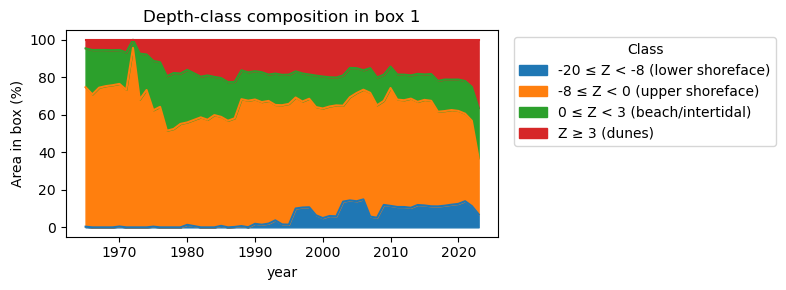

In [39]:
pct_combined.box1.plot.area(figsize=(8,3))
plt.ylabel("Area in box (%)")
plt.title(f"Depth-class composition in box 1")
plt.legend(title="Class", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

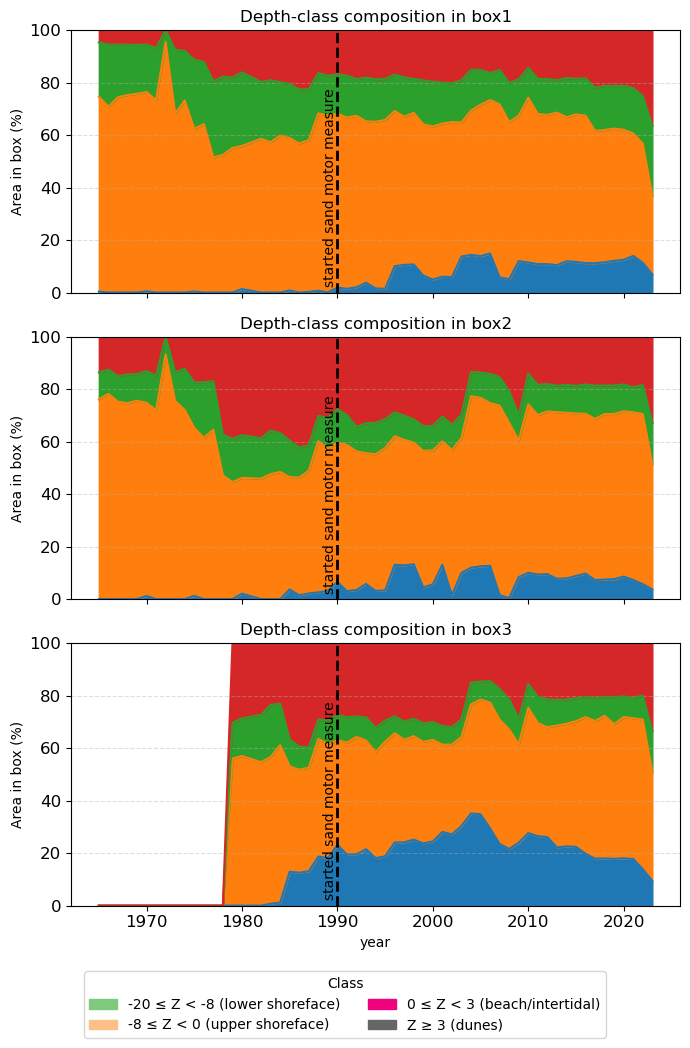

In [59]:
# 3 rows x 1 column: area plots for box1, box2, box3
boxes = ['box1', 'box2', 'box3']
fig, axes = plt.subplots(3, 1, figsize=(7, 10), sharex=True)

for ax, b in zip(axes, boxes):
    if b not in pct_combined.columns.levels[0]:
        ax.text(0.5, 0.5, f'No data for {b}', ha='center', va='center')
        ax.set_title(f'{b} (missing)')
        ax.set_yticks([])
        continue

    dfb = pct_combined[b].sort_index()
    # plot stacked area without per-axis legend (we add a single legend for the figure)
    dfb.plot.area(ax=ax, legend=False)
    ax.set_ylabel("Area in box (%)")
    ax.set_title(f"Depth-class composition in {b}")
    ax.set_ylim(0, 100)
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    ax.tick_params(axis='x', rotation=0)
    # increase font size of y-tick labels
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)


    # add vertical line at 1990; label 'started filling sand motor'
    ax.axvline(x=1990, color='black', linestyle='--', linewidth=2)
    ax.text(1990, 2, 'started sand motor measure', color='black', fontsize=10, ha='right', va='bottom', rotation=90)


# common legend (bottom)
classes = list(pct_combined['box1'].columns) if 'box1' in pct_combined.columns.levels[0] else list(pct_combined.columns.levels[1])
colors = cmap_disc(np.linspace(0, 1, max(len(classes), 1)))
handles = [mpatches.Patch(color=colors[i % len(colors)], label=str(classes[i])) for i in range(len(classes))]
fig.legend(handles=handles, title='Class', loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)

plt.tight_layout(rect=(0, 0.03, 1, 1))
plt.show()

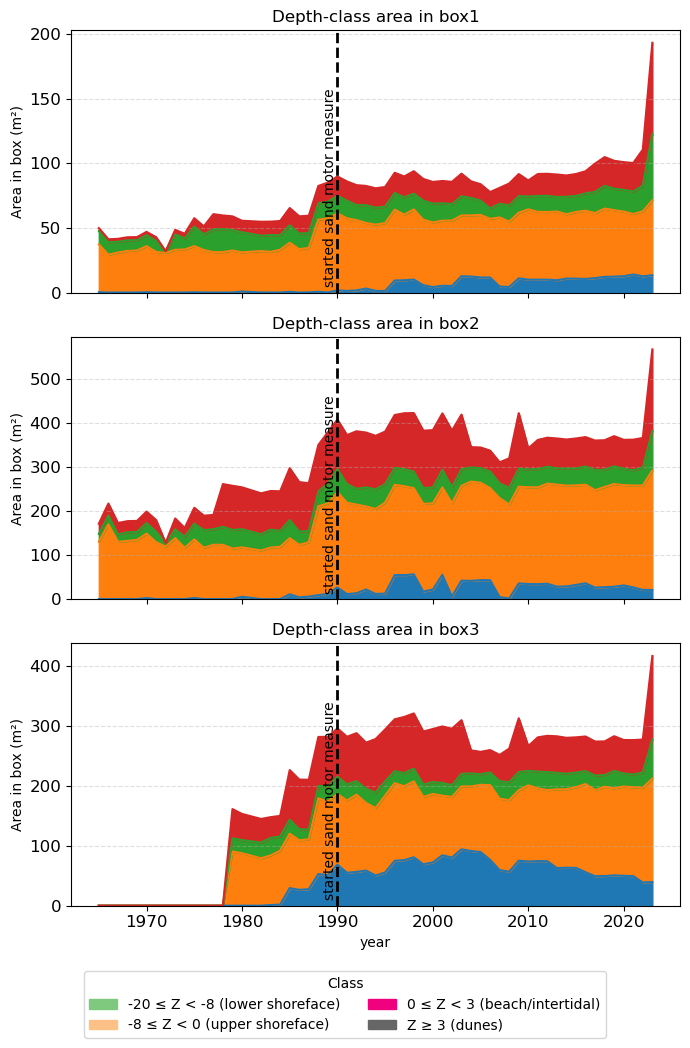

In [64]:
# 3 rows x 1 column: area plots for box1, box2, box3 (use area_combined)
boxes = ['box1', 'box2', 'box3']
fig, axes = plt.subplots(3, 1, figsize=(7, 10), sharex=True)
axes = np.array(axes).ravel()

for ax, b in zip(axes, boxes):
    if area_combined.empty or b not in area_combined.columns.levels[0]:
        ax.text(0.5, 0.5, f'No data for {b}', ha='center', va='center')
        ax.set_title(f'{b} (missing)')
        ax.set_yticks([])
        continue

    dfb = area_combined[b].sort_index()
    dfb.plot.area(ax=ax, legend=False)
    ax.set_ylabel("Area in box (m²)")
    ax.set_title(f"Depth-class area in {b}")
    ax.set_ylim(bottom=0)
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    ax.tick_params(axis='x', rotation=0)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)

    # add vertical line at 1990; label 'started filling sand motor'
    ax.axvline(x=1990, color='black', linestyle='--', linewidth=2)
    ax.text(1990, ax.get_ylim()[1]*0.02, 'started sand motor measure',
            color='black', fontsize=10, ha='right', va='bottom', rotation=90)

# common legend (bottom)
if not area_combined.empty:
    classes = list(area_combined['box1'].columns) if 'box1' in area_combined.columns.levels[0] else list(area_combined.columns.levels[1])
else:
    classes = []

colors = cmap_disc(np.linspace(0, 1, max(len(classes), 1)))
handles = [mpatches.Patch(color=colors[i % len(colors)], label=str(classes[i])) for i in range(len(classes))]
fig.legend(handles=handles, title='Class', loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)

plt.tight_layout(rect=(0, 0.03, 1, 1))
plt.show()

In [68]:
# sum area in each box for each year (area_combined is present)
if not area_combined.empty:
    # group columns by the top-level (box name) and sum across classes
    total_area = area_combined.groupby(level=0, axis=1).sum()
    total_area = total_area.sort_index()
    total_area.index = total_area.index.astype(int)
    total_area = total_area.rename(columns=lambda x: f'{x} total area (m²)')
    display(total_area)


C:\Users\Move\AppData\Local\Temp\ipykernel_14328\3535735304.py:4: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  total_area = area_combined.groupby(level=0, axis=1).sum()


,box1 total area (m²),box2 total area (m²),box3 total area (m²)
year,,,
1965,49.8510,171.210,0.0000
1966,41.1945,217.035,0.0000
1967,41.5425,172.770,0.0000
1968,42.7605,177.060,0.0000
1969,42.8910,177.645,0.0000
1970,46.9365,198.705,0.0000
1971,42.8475,179.595,0.0000
1972,32.0160,127.530,0.0000
1973,48.5025,183.105,0.0000
